In [2]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

import matplotlib
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context

sc.set_figure_params(format="png")
import anndata as ad
import seaborn as sns
from PIL import Image
from scipy import ndimage
from skimage import exposure, measure, morphology
from sklearn.cluster import MiniBatchKMeans
import math
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [5]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

# import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
]


# Read info

In [7]:
# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


In [25]:
# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_flowjo.h5ad"
adata = sc.read_h5ad(adata_path)

# # Read single-cell data
# adata_path = data_dir / "metadata" / f"combined_flowjo.h5ad"
# adata = sc.read_h5ad(adata_path)

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [26]:
old_to_new = {
    'Plasma Cells':'PB/PC',
}
adata.obs['Phenotype'] = (
    adata.obs['Phenotype']
    .apply(lambda x: old_to_new.get(x,x))
    .astype('category')
)

In [27]:
sc.tl.dendrogram(adata, groupby='Phenotype')


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Phenotype']`


In [28]:
import matplotlib 

var = 'Phenotype'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}




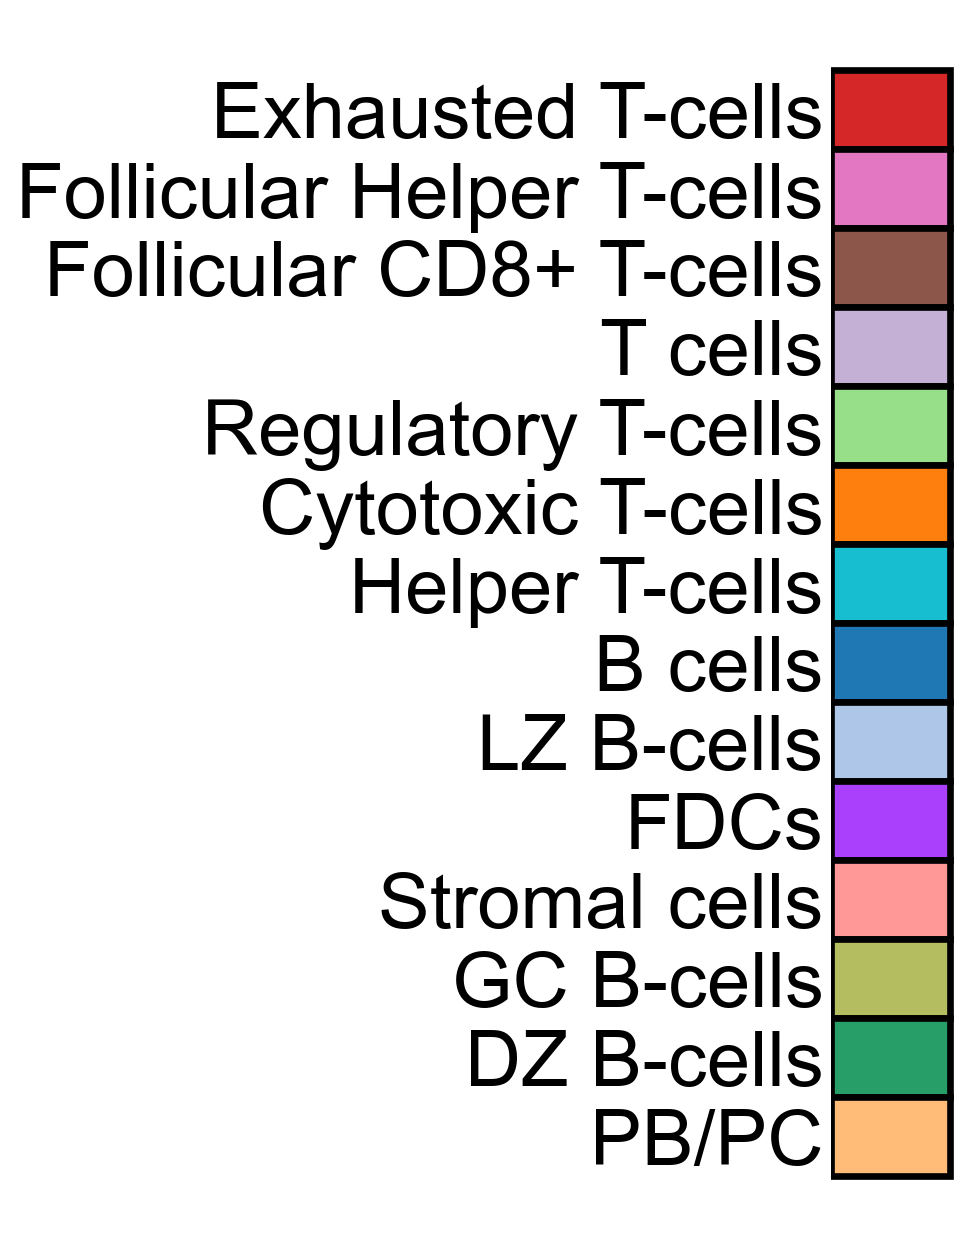

In [29]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,10))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [39]:
var = 'Phenotype' 
df_cluster = pd.DataFrame()
df_cluster["Dataset"] = adata.obs['Dataset'].tolist()
df_cluster["Dataset"] = df_cluster["Dataset"].astype(str).astype('category')
df_cluster[var] = adata.obs['Phenotype'].tolist()
df_cluster_count = df_cluster.value_counts().to_frame('counts').reset_index()

df_cluster_count['Density'] = df_cluster_count['counts'] / df_cluster_count.groupby("Dataset")["counts"].transform('sum')

In [40]:
cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()
colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v/255 for k,v in zip(labels, colors_rgb)}

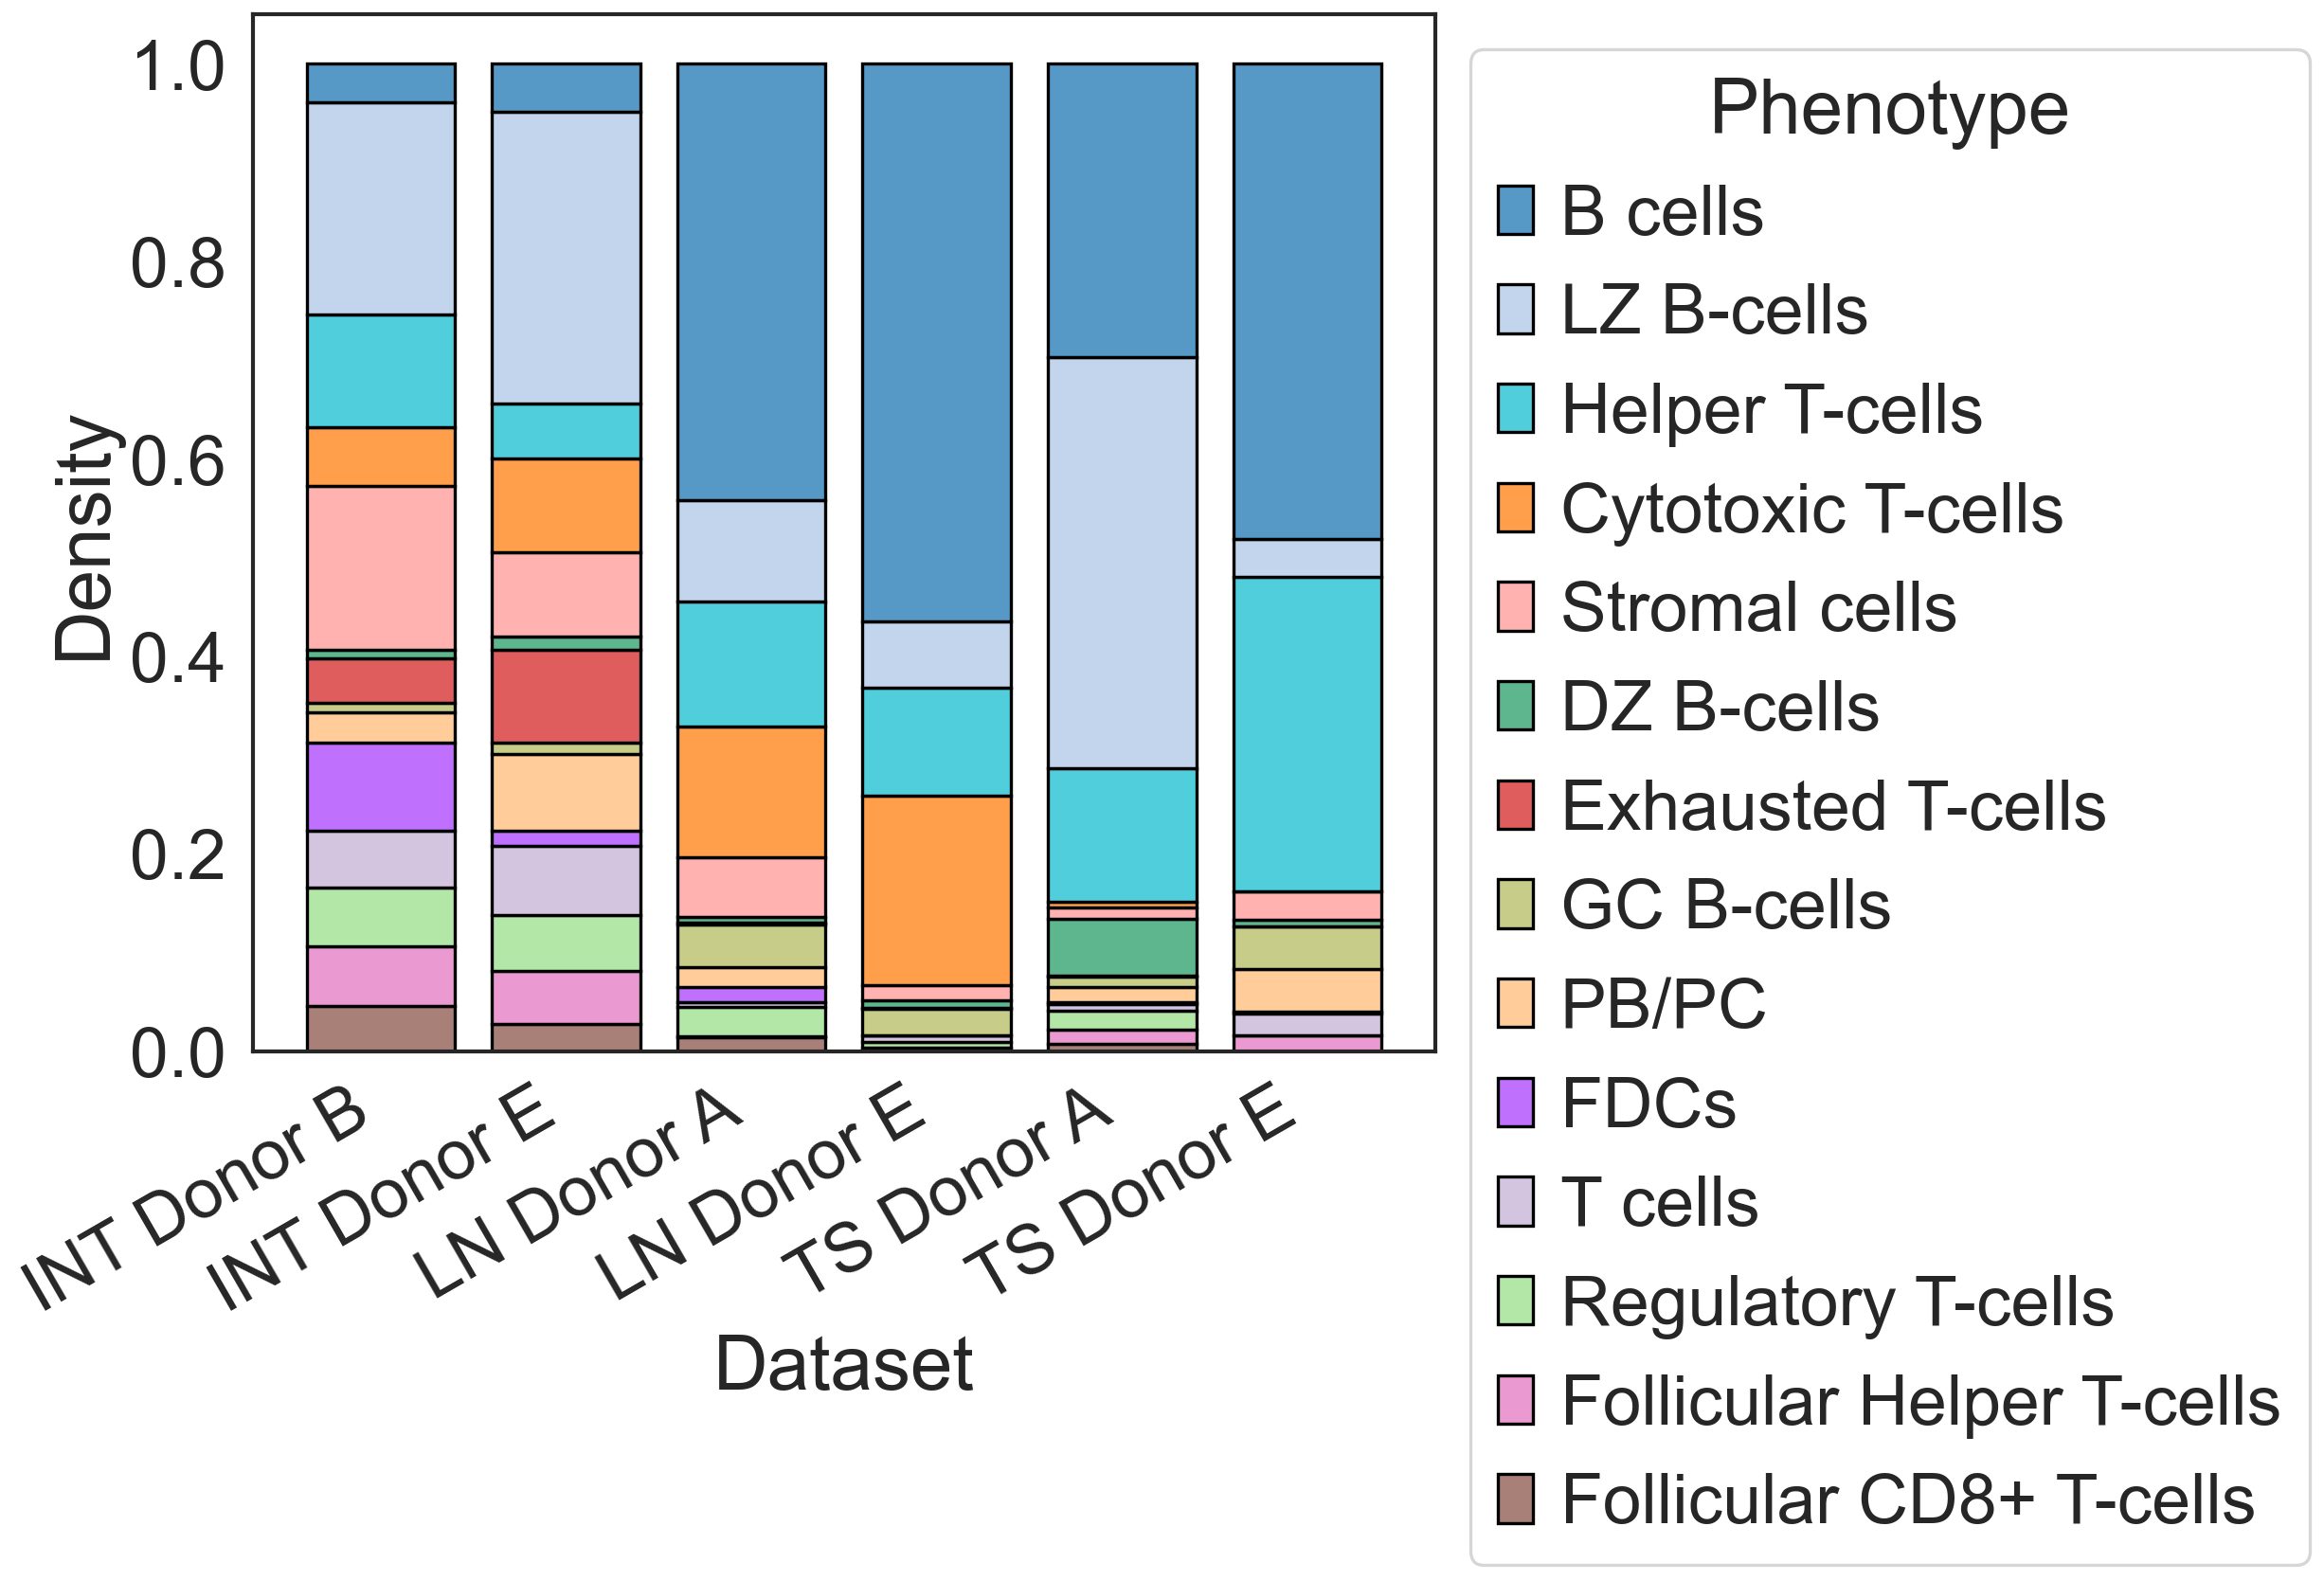

In [41]:
sns.set_style('white')
with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(10, 9))
    ax = sns.histplot(data=df_cluster_count, x="Dataset" , hue=var, weights='Density', discrete=True, multiple='stack', shrink=0.8, palette=colors_rgb_dict, edgecolor='k',)
    ax.set_ylabel('Density')

    # Fix the legend so it's not on top of the bars.
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1, 1))
    plt.xticks(rotation=30, ha='right')


In [76]:
df = sc.get.obs_df(adata, keys=adata.obs.columns.tolist())

In [77]:
df_count = df.groupby(['Dataset']).size()
df_count.to_clipboard()

In [78]:
df_count = df.groupby(['Phenotype']).size()
df_count.to_clipboard()

In [79]:
phenotypes = adata.obs.Phenotype.unique()

In [81]:
len(phenotypes)

16

C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.s

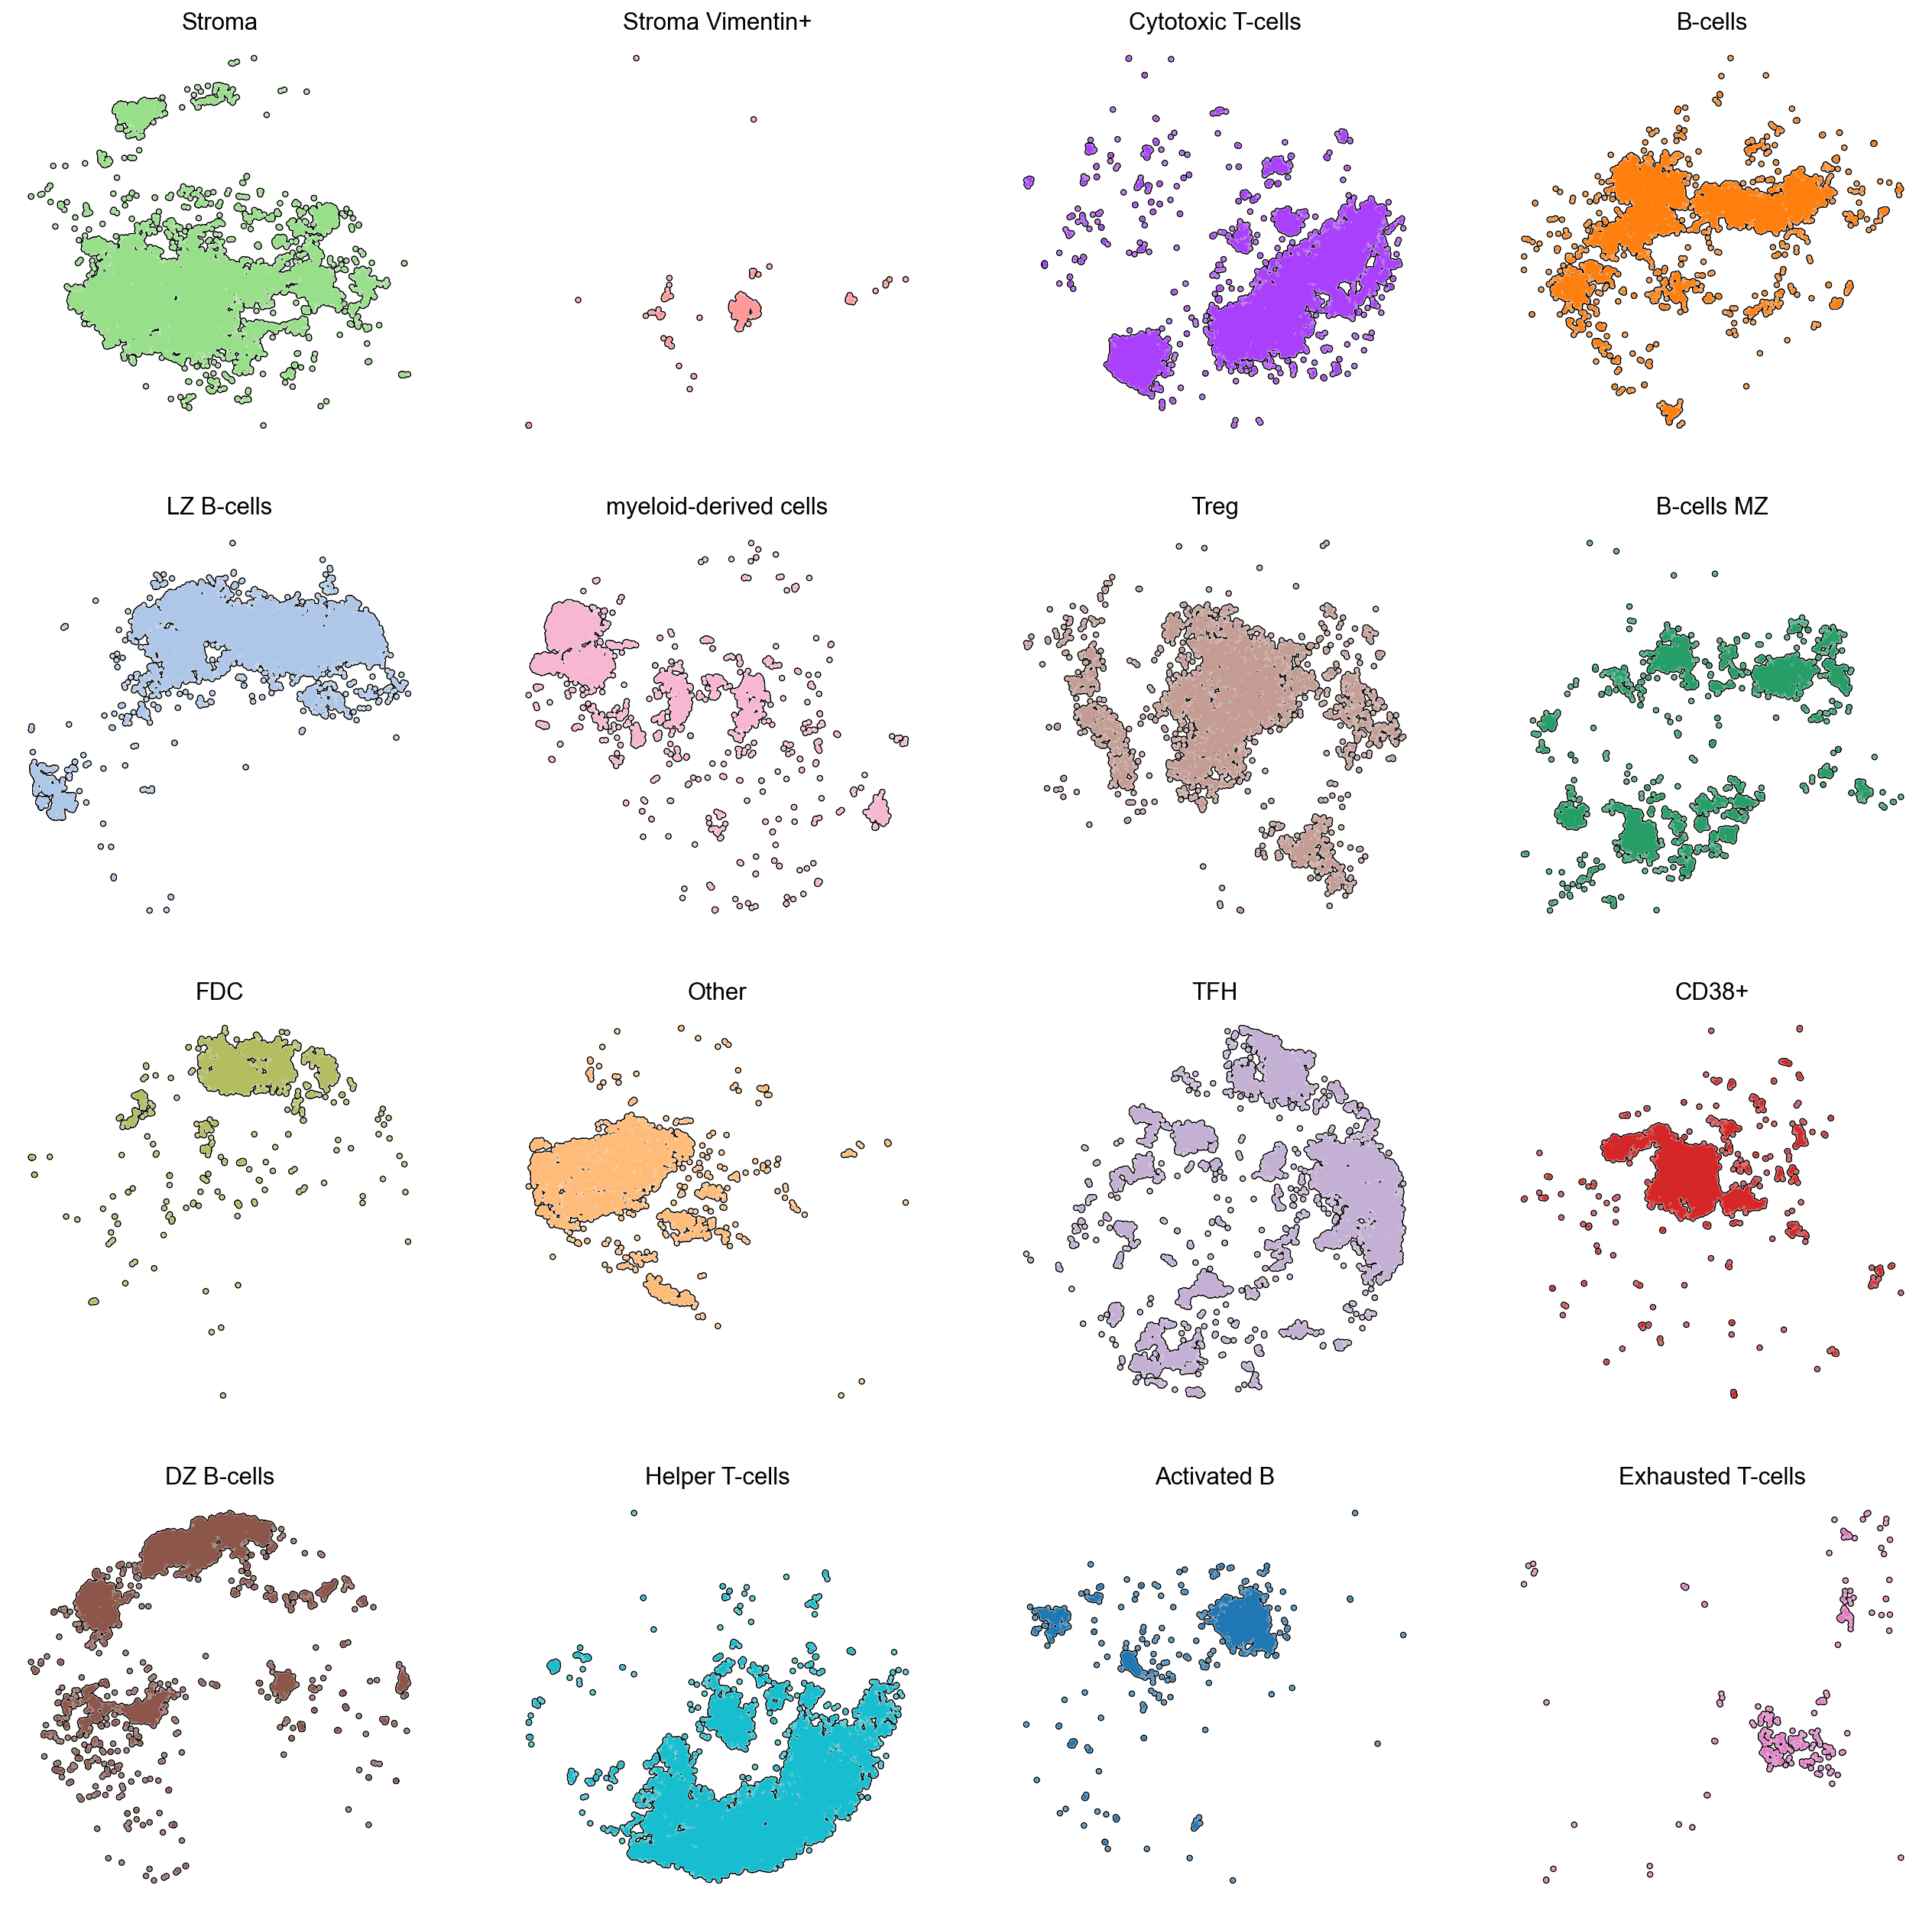

In [80]:
# n = 5
# adata_subset = adata[::n]

# fig, axs = plt.subplots(4,4, figsize=(20,20))
# axs = axs.flatten()
# for i, ax in enumerate(axs):
#     try:
#         sc.pl.tsne(adata_subset[adata_subset.obs.Phenotype == phenotypes[i]], color='Phenotype', ax=axs[i], size=20, add_outline='True',
#                   legend_loc=None, frameon=False, show=False)
#         ax.title.set_text(phenotypes[i])
#     except:
#         ax.axis('off')    
# plt.show() 